# Module 3 DBSCAN Clustering

Cluster Analysis is an important problem in data analysis. It is used to cluster data to do market research, pattern recognition, image processing, classifying documents for information discovery, credit card fraud detection, grouping genes with similar patterns and so many other applications.

There are different types of Clustering algorithms as we have K-Means and Hierarchical in other lab notebooks. K-Means determines k centroids in the data and clusters points by assigning points to the nearest centroid.

While K-Means is easy to understand and implement, it cannot detect any outliers in data. All points are assigned to a cluster even if they do not belong in any. But in reality this causes a problem as anomalous points will be assigned to the same cluster as "normal" valid data points. The anomalous points pull the cluster centroid towards them, making it harder to classify them as anomalous points.

Another type of clustering methods are density-based. Compared to centroid-based clustering like K-Means, density-based clustering works by identifying "dense" clusters of points, allowing it to learn clusters of arbitrary shape and identify outliers in the data. This lab notebook discusses popular DBSCAN algorithm.

### $\epsilon$ neighborhood and neighborhood density

**ɛ-neighborhoods:** Given a data point, identify the data points around in the space arund it. For some real-valued ɛ > 0 and some point **p**, the $\epsilon$-neighborhood of p is defined as the set of points that are at most distance $\epsilon$ away from **p**.

The shape in which all points are equidistant from the center will be a circle. In a 2D space, the $\epsilon$-neighborhood of a point **p** is the set of points contained in the circle of radius $\epsilon$, centered at **p**. In 3D space, the $\epsilon$-neighborhood is a sphere of radius $\epsilon$, centered at **p**, and in higher dimensional space, the $\epsilon$-neighborhood is just the N-sphere of radius $\epsilon$, centered at **p**.

Consider a dummy dataset generated using numpy.random numbers. There are 50 data points. Lets choose the center as (0,0) which wil be the point p in the discussion.

In [1]:
import numpy as np

# Generate 50 random random numbers in a normal distribution
x=np.random.randn(50)

# generate 50 random random numbers in a normal distribution and add x to it, so that x and y are correlated. 
# Because every element of y contains x which makes them co related
y=x+np.random.randn(50)

print(x[1:5])
print(y[1:5])

[-0.63824557  0.05645952  0.63121087 -1.66671588]
[ 0.01023674  0.22814629  1.20382733 -4.48551585]


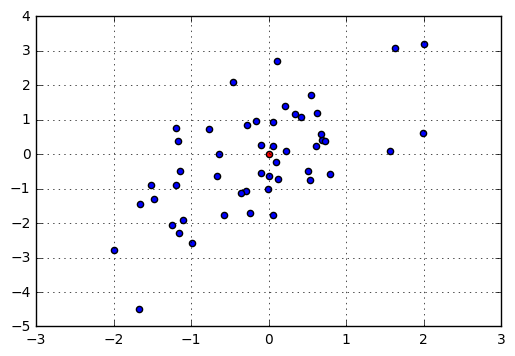

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Draw scatter plot for x and y
plt.scatter(x,y)

# Highlight the chosen point p in red color
plt.scatter(0, 0, c='r')  # plot interesting points in red again

# enable grid on the plot
plt.grid()

First, let’s consider the neighborhood of p with radius 0.5 (ɛ = 0.5), the set of points that are distance 0.5 away from p.

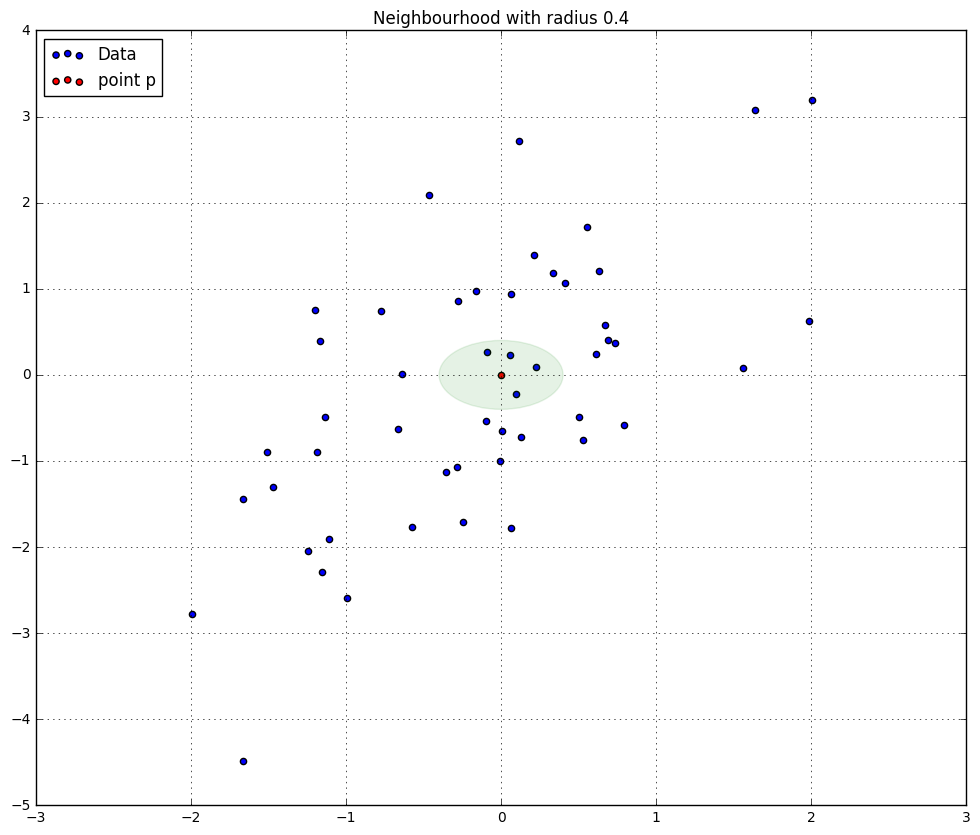

In [5]:
# Create a circle around the point (0,0) with radius 0.4. color='g' lets the circle be of color green and fill=True 
# fills the circle. alpha=0.1 tells how thick the circle should be filled. It ranges from  to 1. 0 being no fill to 1 being 
# completely filled. A value of 0.1 will make the circle look transparent. 
circle = plt.Circle((0, 0), 0.4, color='g', fill=True, alpha=0.1)

# generate a figure with size as mentioned
fig, ax = plt.subplots(figsize=(12, 10))

# draw scatter plot using x and y
plt.scatter(x,y,  label = "Data")

# Highlight the point p again. 
plt.scatter(0, 0, c='r', label = "point p")  # plot interesting points in red again
plt.grid()

# Add legend to the plot. loc=2 will tell python to put legend at top left corner. You can try different loc values like 1,2,3,4
plt.legend(loc = 2)
plt.title("Neighbourhood with radius 0.4")

# add the circle created above to the plot. 
ax.add_artist(circle)

The green oval represents the neighborhood of point **p**, and there are 3 data points in this neighborhood. Since there are a total of 50 scattered data points and 3 are in the neighborhood, this means that under one-tenth of the data points are contained within the neighborhood of p with radius 0.4.

Now change the radius to 0.2 ($\epsilon$ = 0.2) and consider the resulting smaller neighborhood.

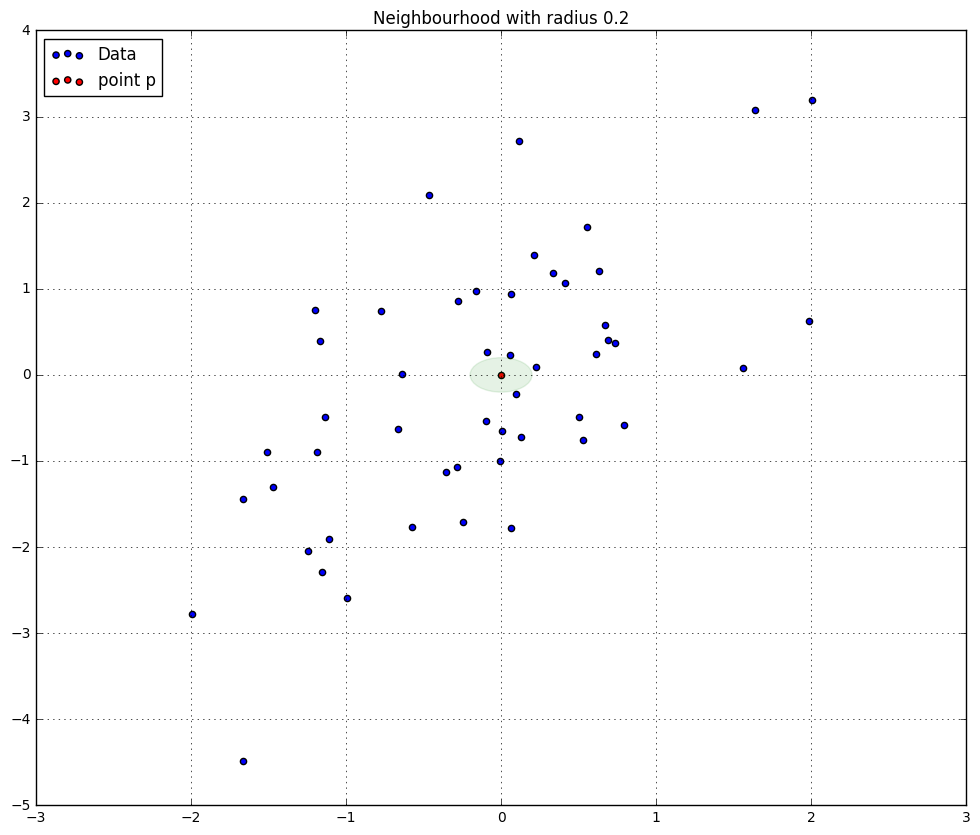

In [6]:
circle = plt.Circle((0, 0), 0.2, color='g', fill=True, alpha=0.1)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(x,y,  label = "Data")
plt.scatter(0, 0, c='r', label = "point p")  # plot interesting points in red again
plt.grid()
plt.legend(loc = 2)
plt.title("Neighbourhood with radius 0.2")
ax.add_artist(circle)

The neighborhood has shrunk. There is only 1 data point in it now. By decreasing $\epsilon$ from 0.4 to 0.2 (a 50% reduction), the number of points in the neighborhood decreased from 3 to 1 (a 67% reduction).

**Density of a neighborhood: **  If you go back to your science text book in high school, density is given as

$$density = \frac{mass}{volume}$$. 

Use this idea of mass divided by volume to define density at point p. Consider a point p and its neighborhood of radius $\epsilon$, the mass of the neighborhood can be defined as the number of data points contained within the neighborhood, and the volume of the neighborhood is volume of the resulting shape of the neighborhood. Here the neighborhood is a circle, so the volume of the neighborhood is the area of the resulting circle.

For example, consider the neighborhood of point p = (0,0) of radius 0.4

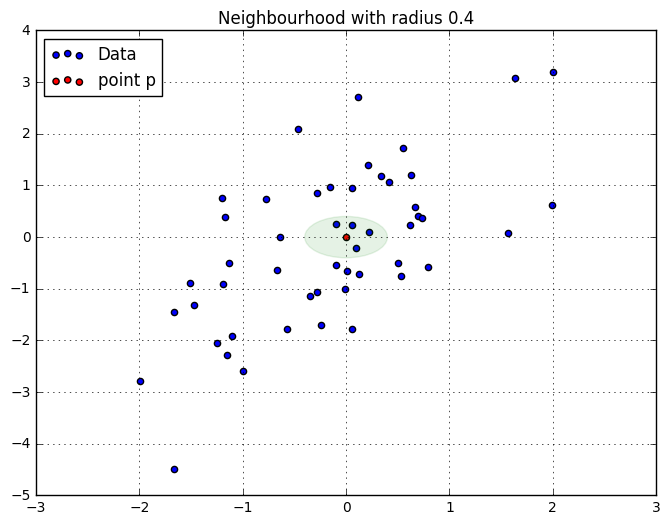

In [7]:
circle = plt.Circle((0, 0), 0.4, color='g', fill=True, alpha=0.1)
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x,y,  label = "Data")
plt.scatter(0, 0, c='r', label = "point p")  # plot interesting points in red again
plt.grid()
plt.legend(loc = 2)
plt.title("Neighbourhood with radius 0.4")
ax.add_artist(circle)

The mass is the number of data points in the neighborhood, so mass = 3. The volume is the area of the circle, so volume = $\pi$ * 0.52 = $\pi$/4. Therefore, the local density approximation at **p** = (0,0) is calculated as density = mass/volume = 3/($\pi$/4) = 12/$\pi$ ~= 3.82.

This single density value is meaningless by itself, but when local density approximation for all points in the dataset is calculated, then points can be clustered by saying that points that are nearby (contained in the same neighborhood) and have similar local density approximations belong in the same cluster. If the value of $\epsilon$ is decreased, smaller neighborhoods (less volume) are formed which will contain fewer data points. DBSCAN tries to identify highly dense neighborhoods where most of the data points are contained in these neighborhoods, but the volume of each of these neighborhoods is relatively small.

This is the general intuition behind a density-based clustering algorithm.

DBSCAN, unlike K-Means does not require the number of clusters as a parameter. It will infer the number of clusters based on the data, and it can discover clusters of arbitrary shape which K-Means cannot. DBSCAN algorithm has two parameters:

- $\epsilon$: The radius of neighborhood around a data point p.
- minPts: The minimum number of data points that should be in a neighborhood to define a cluster.

Using abve two parameters, DBSCAN categories the data points into three categories:

- **Core Points:** A data point p is a core point if $\epsilon$-neighborhood of p contains at least minPts

- **Border Points:** A data point q in the dataset is a border point if $\epsilon$-neighborhood of q contains less than minPts data points, but q is reachable from some core point p.

- **Outlier:** A data point o is an outlier if it is neither a core point nor a border point. Essentially, this is the “other” class.

Let’s discuss these definitions little in depth. 

**Core Points**

Core Points are the foundations of clusters. The core points are based on the density approximation. The same $\epsilon$ is used to compute the neighborhood for each point, so the volume of all the neighborhoods is same. However, the number of other points in each neighborhood is what differs. 

The number of data points in the neighborhood can be treated as its mass. The volume of each neighborhood is constant, and the mass of neighborhood is variable, so by putting a threshold on the minimum amount of mass needed to be core point, we are essentially setting a minimum density threshold. Therefore, core points are data points that satisfy a minimum density requirement. The clusters are built around the core points, so by adjusting the minPts parameter the density of clusters can be fin etuned.

**Border Points: **

Border Points are the points in the clusters that are not core points. The term density-reachable is used in the definition above. Lets create a neighborhood with epsilon = 0.65 for our point p(0,0). Consider the point r (the black dot) that is outside of the point p's neighborhood.

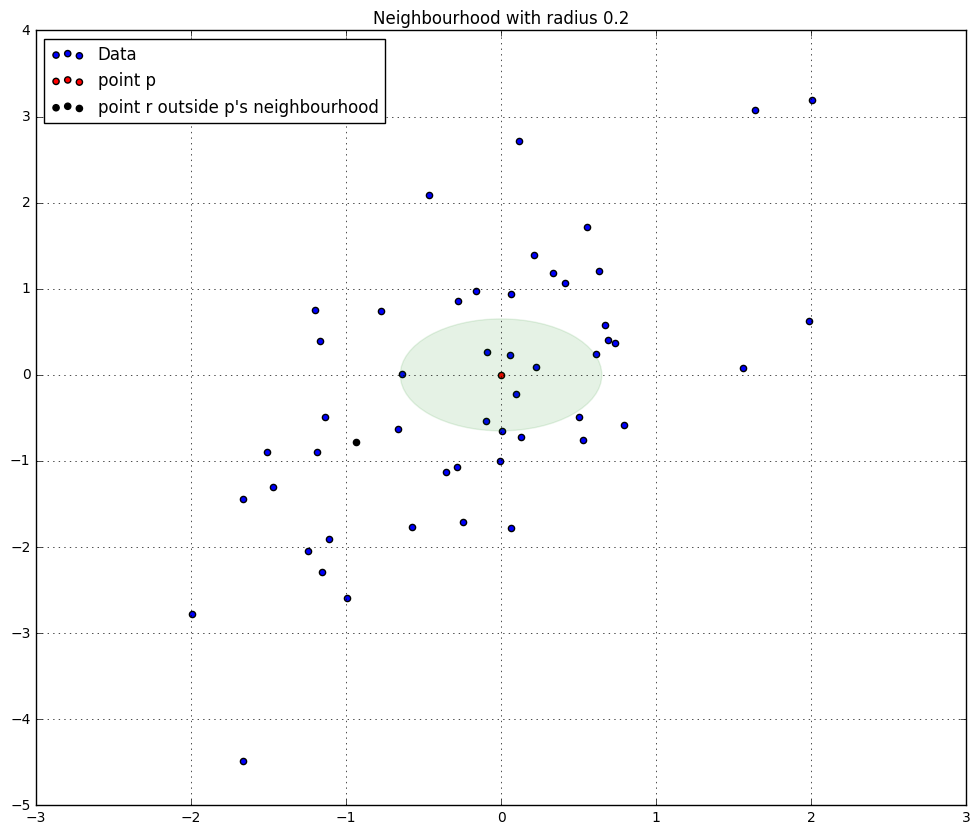

In [8]:
circle1 = plt.Circle((0, 0), 0.65, color='g', fill=True, alpha=0.1)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(x,y,  label = "Data")
plt.scatter(0, 0, c='r', label = "point p")  # plot interesting points in red again
plt.scatter(-0.93343688,-0.78195153, c='black', label = "point r outside p's neighbourhood")  # plot interesting points in red again
plt.grid()
plt.legend(loc = 2)
plt.title("Neighbourhood with radius 0.2")
ax.add_artist(circle1)

All the points inside the point p's neighborhood are directly reachable from p. Let’s explore the neighborhood of another point q, a point directly reachable from p. purple circle represents q's neighborhood.

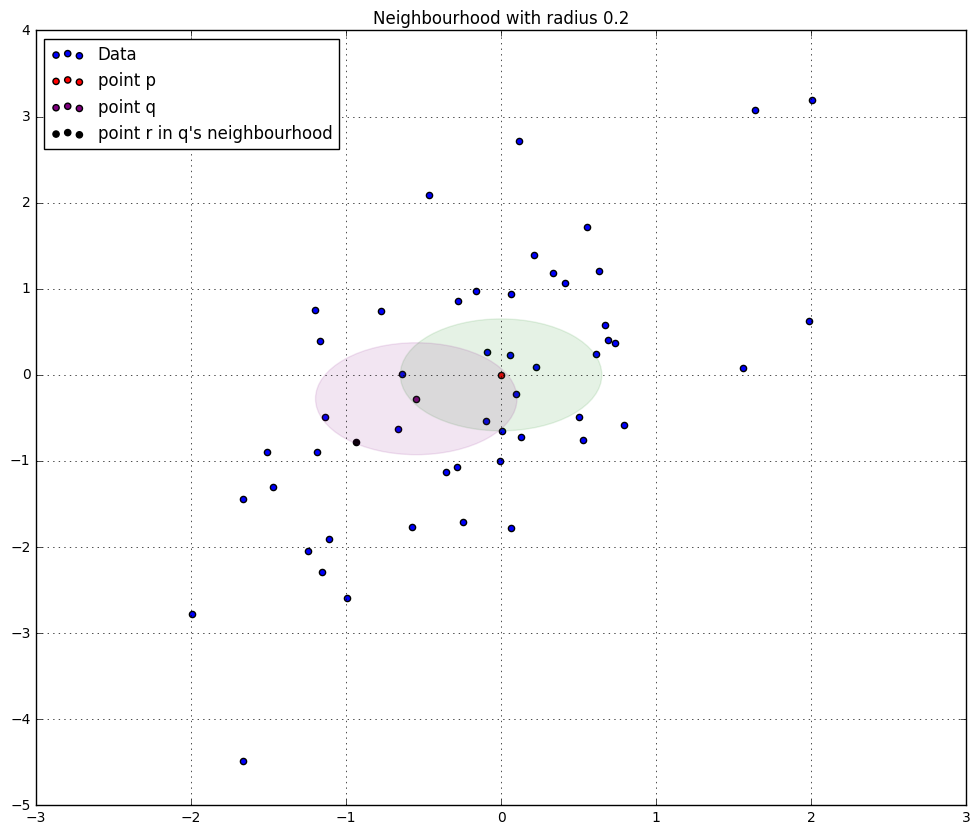

In [9]:
import matplotlib.patches as patches

circle1 = plt.Circle((0, 0), 0.65, color='g', fill=True, alpha=0.1)
# patches.Circle((0.82, 0.5), 0.1,alpha=0.1)
circle2 = plt.Circle((-0.54701334,-0.27689633), 0.65, color='purple', fill=True, alpha=0.1, label = "Neighborhood")
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(x,y,  label = "Data")
plt.scatter(0, 0, c='r', label = "point p")  # plot interesting points in red again
plt.scatter(-0.54701334,-0.27689633, c='purple', label = "point q")  # plot interesting points in red again
plt.scatter(-0.93343688,-0.78195153, c='black', label = "point r in q's neighbourhood")  # plot interesting points in red again
plt.grid()
plt.legend(loc = 2)
plt.title("Neighbourhood with radius 0.2")
ax.add_artist(circle1)
ax.add_artist(circle2)

The target point r is not the starting point p's neighborhood, it is contained in the point q's neighborhood. Basically this is the idea behind density-reachable. If we can get to the point r by jumping from neighborhood to neighborhood, starting at a point p, then the point r is density-reachable from the point p.

It is important to note that this idea of density-reachable is dependent on the value of $\epsilon$. By picking larger values of $\epsilon$, more points become density-reachable, and by choosing smaller values of $\epsilon$, less points become density-reachable.

**Outliers: **

Finally, the points which are neither core nor desnity-reachable from a core point that are grouped into "other" class. Outliers are not assigned to any cluster and, depending on the context, may be considered anomalous points.

### Steps for DBSCAN algorithm:

- Pick a point at random that has not been assigned to a cluster or been designated as an outlier. Compute its neighborhood to determine if it’s a core point. If yes, start a cluster around this point. If no, label the point as an outlier.


- Once core point and a cluster is identified , expand the cluster by adding all directly-reachable points to the cluster. Perform “neighborhood jumps” to find all density-reachable points and add them to the cluster. If an an outlier is added, change that point’s status from outlier to border point.


- Repeat above steps until all points are either assigned to a cluster or designated as an outlier.

Python's Scikit-Learn library has the iplementation of DBSCAN algorithm. So just use the functions. 

### DBSCAN Implementtaion
----
Lets move on to applying DBSCAN algorithm on a dataset to compare the clusters it forms with KMeans. Apply the algorithm on wholesale dataset from UCI machine learning repository. The dataset consists of annual customer data for a wholesale distributor. It has data about 440 customers and has 8 attributes for each of these customers. Use Pandas library to load the .csv file into a DataFrame object.

In [1]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [2]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [3]:
wholesale_data = pd.read_csv("../../../datasets/wholesale/Wholesale_customers_data.csv")
wholesale_data.drop(["Channel", "Region"], axis = 1, inplace = True)

The first two fields identify the customer. They are deleted above. Examine the first few rows of the dataset using head().

In [4]:
wholesale_data.head(5)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


For illustrating the working of algorithm, data only with below two attributes are used.

- **Groceries:** The customer’s annual spending on grocery products.

- **Milk:** The customer’s annual spending on milk products.

In [14]:
wholesale_data = wholesale_data[["Grocery", "Milk"]]
wholesale_data = wholesale_data.as_matrix().astype("float32", copy = False)

The StandardScalar() function below will normalize each attribute by scaling it to 0 mean and unit variance. All attribute values represent spendings of customer by some monetary unit. 

In [15]:
stscaler = StandardScaler().fit(wholesale_data)
data = stscaler.transform(wholesale_data)

Below plot is for the normalized data

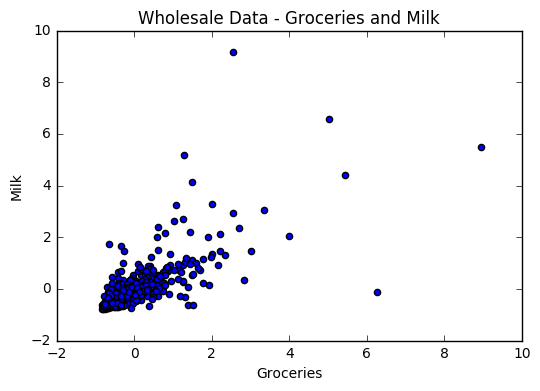

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(data[:,0], data[:,1])
plt.xlabel("Groceries")
plt.ylabel("Milk")
plt.title("Wholesale Data - Groceries and Milk")

From the above plot it is evident that there is a positive correlation between grocery purchases and milk product purchases. There is a cluster centered about the mean milk purchase (milk = 0) and the mean groceries purchase (groceries = 0). Also there are few outliers pertaining to customers who buy more wgroceries or milk products compared to other customers.

With DBSCAN, lets try to identify this main cluster of customers and flag those customers with more unusual annual purchasing habits as outliers.

Below piece of code will construct a DBSCAN object that requires a minimum of 15 data points in a neighborhood of radius 0.5 to be considered a core point.

In [17]:
dbscan_res = DBSCAN(eps = .5, min_samples = 15).fit(data)

Here we are extracting the cluster labels and outliers to plot the results.

In [18]:
import numpy as np

labels = dbscan_res.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbscan_res.core_sample_indices_] = True

In [19]:
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0,1, len(unique_labels)))

/usr/lib64/python3.4/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


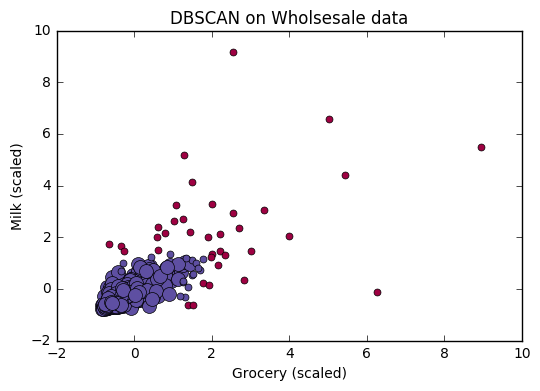

In [20]:
for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    xy = data[class_member_mask & core_samples]
    plt.plot(xy[:,0],xy[:,1], 'o', markerfacecolor = color, markersize = 10)
    
    xy2 = data[class_member_mask & ~core_samples]
    plt.plot(xy2[:,0],xy2[:,1], 'o', markerfacecolor = color, markersize = 5)
    
plt.title("DBSCAN on Wholsesale data")
plt.xlabel("Grocery (scaled)")
plt.ylabel("Milk (scaled)")

From above plot, we can say DBSCAN algorithm was able to identify one cluster of customers who are about the mean grocery and mean milk product purchases. In addition, it was able to flag customers whose annual purchasing behavior deviated too heavily from other customers.

Because the outliers corresponded to customers with more extreme purchasing behavior, the wholesale distributor could specifically target these customers with exclusive discounts to encourage larger purchases.

As a baseline, let’s run K-Means with two clusters. The blue dot represents the centroid for the red cluster, and the big gold dot represents the centroid for the blue cluster.

In [21]:
kmeans = KMeans(n_clusters = 2).fit(data)
labels_kmeans = kmeans.labels_
centroids = kmeans.cluster_centers_

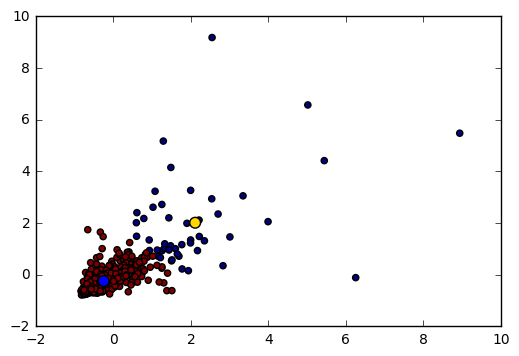

In [22]:
plt.scatter(data[:,0], data[:,1], c = labels_kmeans)
plt.scatter(centroids[:,0], centroids[:,1], c = ["gold","blue"], s = 60)

While the blue clusters appears to capture most of the outliers, the cluster basically captures customers who purchase relatively more goods. If the blue cluster is designated as the "anomalous" cluster, We are basically flagging any customer who purchases a lot of milk or groceries.